In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# %reset

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = "/content/drive/My Drive/Colab Notebooks/Deep Learning/SOBAN_BSCS16022_05_part2/A_05_Part_02_Dataset"

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=train_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle=True, num_workers=4)


print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['0.covid-19', '1.pneumonia', '2.normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


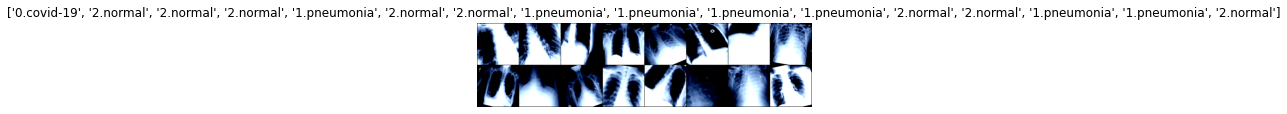

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [6]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [7]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(num_features)
print(features)

25088
[]


In [0]:
features.extend([nn.Linear(num_features, (22*10+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((22*10+100), len(class_names))])
# features.extend([nn.Sigmoid()])

In [9]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
pos_weight = torch.ones([3])

# alpha = 0.28
# gamma = 2.1
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

# BCE = torch.nn.functional.binary_cross_entropy_with_logits(y_pred , t , reduction='none')
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

**Training**

In [11]:
from tqdm import tqdm
train_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
epochs_array = []
acc_per_epoch = []
loss_per_epoch = []
correct_train = 0
total_train = 0

val_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
val_epochs_array = []
val_acc_per_epoch = []
val_loss_per_epoch = []
correct_val = 0
total_val = 0

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total_train = 0
      correct_train = 0
      running_loss = 0

      val_running_loss = 0.0
      total_val = 0
      correct_val = 0
      val_running_loss = 0

      pbar = tqdm(enumerate(trainloader), position=0, leave=True)
      for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            one_hot_labels.append([0, 0, 1])
        one_hot_labels = torch.Tensor(list(one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        outputs = outputs.float()
 
        loss = criterion(outputs.cuda(), one_hot_labels.cuda()) #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        total_train += labels.size(0)

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_train += 1
            train_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[2][2] += 1

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        

        #====================================================== Validation =====================================================


      pbar2 = tqdm(enumerate(validationloader), position=0, leave=True)
      for i, data in pbar2:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        val_one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            val_one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            val_one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            val_one_hot_labels.append([0, 0, 1])
        val_one_hot_labels = torch.Tensor(list(val_one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        outputs = outputs.float()
 
        loss = criterion(outputs.cuda(), val_one_hot_labels.cuda())  #----> compute loss

        # outputs = vgg16(images)
        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          total_val += 1
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_val += 1
            val_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[2][2] += 1

          val_running_loss += loss.item()
      #========================================================================================================================
        
      epochs_array.append(epoch)
      acc_per_epoch.append(100 * (correct_train / total_train))
      loss_per_epoch.append(running_loss)

      val_acc_per_epoch.append(100 * (correct_val / total_val))
      val_loss_per_epoch.append(val_running_loss)

torch.save(vgg16.state_dict(), "/content/drive/My Drive/Colab Notebooks/Deep Learning/SOBAN_BSCS16022_05_part2/vgg16_ft.pth")

print('Finished Training')

cuda:0


Train Epoch: 0 [56/6200 (2%)]	Loss: 0.267308: : 388it [13:40,  2.11s/it]
40it [01:27,  2.19s/it]
Train Epoch: 1 [56/6200 (2%)]	Loss: 0.052800: : 388it [02:21,  2.74it/s]
40it [00:12,  3.16it/s]
Train Epoch: 2 [56/6200 (2%)]	Loss: 0.403075: : 388it [02:23,  2.70it/s]
40it [00:12,  3.13it/s]
Train Epoch: 3 [56/6200 (2%)]	Loss: 0.293776: : 388it [02:23,  2.70it/s]
40it [00:13,  3.06it/s]
Train Epoch: 4 [56/6200 (2%)]	Loss: 0.105977: : 388it [02:25,  2.66it/s]
40it [00:12,  3.13it/s]
Train Epoch: 5 [56/6200 (2%)]	Loss: 0.037718: : 388it [02:23,  2.70it/s]
40it [00:12,  3.14it/s]
Train Epoch: 6 [56/6200 (2%)]	Loss: 0.098197: : 388it [02:23,  2.70it/s]
40it [00:12,  3.18it/s]
Train Epoch: 7 [56/6200 (2%)]	Loss: 0.558092: : 388it [02:23,  2.70it/s]
40it [00:12,  3.11it/s]
Train Epoch: 8 [56/6200 (2%)]	Loss: 0.115536: : 388it [02:24,  2.68it/s]
40it [00:12,  3.16it/s]
Train Epoch: 9 [56/6200 (2%)]	Loss: 0.274564: : 388it [02:24,  2.69it/s]
40it [00:12,  3.13it/s]


Finished Training


Train Epochs :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Train Loss :  [119.9969869479537, 92.07603005506098, 82.16949091665447, 77.78926337510347, 73.28912563063204, 73.72656679339707, 70.0097445724532, 67.4558795997873, 67.17385279946029, 65.74361308198422]
Train Accuracy :  [14.000000000000002, 9.870967741935484, 8.758064516129032, 8.661290322580644, 8.403225806451612, 9.032258064516128, 8.161290322580646, 8.14516129032258, 8.14516129032258, 8.580645161290322]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Train Set Confusion Matrix
[[  363   516  1076]
 [  125  3386 16111]
 [   21 37548  1940]]


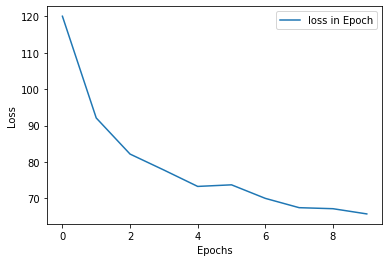

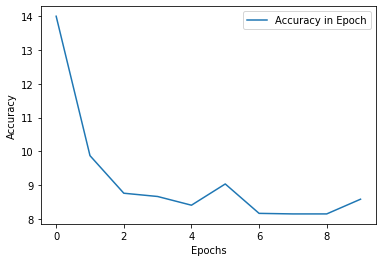

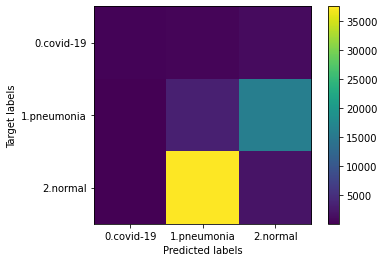

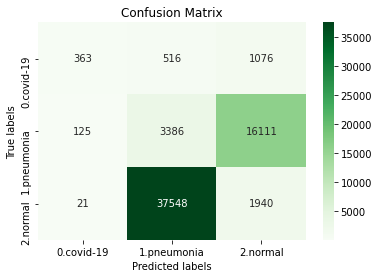

In [12]:
print("Train Epochs : " ,epochs_array)
print("Train Loss : ", loss_per_epoch)
print("Train Accuracy : ", acc_per_epoch)
plt.plot(epochs_array, loss_per_epoch, label = "loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, acc_per_epoch, label = "Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Train Set Confusion Matrix")
print(train_confusion_Matrix_vgg)
plt.imshow(train_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(train_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

Validation Epochs :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Validation loss :  [882.2733011245728, 1224.666036605835, 983.8616428375244, 1489.495325088501, 1602.7399864196777, 1364.1257152557373, 1455.420066833496, 1651.458583831787, 1546.7940664291382, 1445.6616396903992]
Validation Accuracy :  [82.32484076433121, 87.26114649681529, 86.14649681528662, 87.26114649681529, 89.171974522293, 89.01273885350318, 90.76433121019109, 91.2420382165605, 89.171974522293, 90.12738853503186]
Validation Set Confusion Matrix
[[  54  102  114]
 [   7 3754  192]
 [   9  239 1734]]


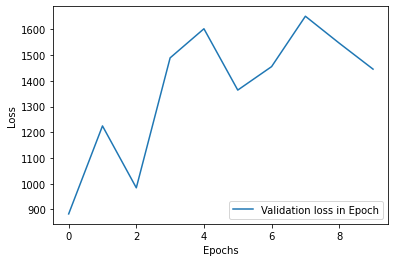

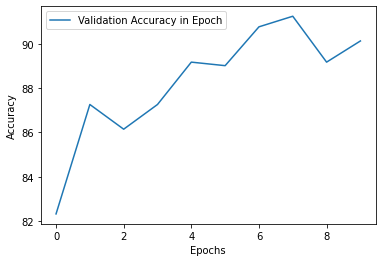

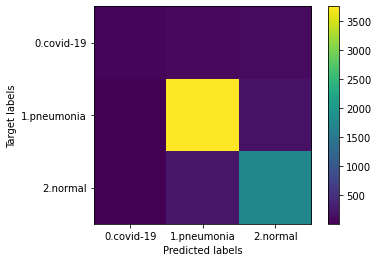

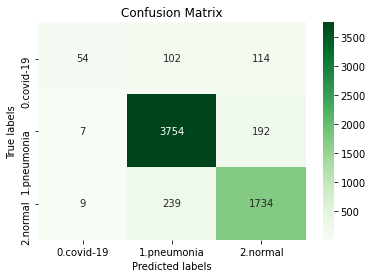

In [13]:
print("Validation Epochs : ", epochs_array)
print("Validation loss : ", val_loss_per_epoch)
print("Validation Accuracy : ", val_acc_per_epoch)
plt.plot(epochs_array, val_loss_per_epoch, label = "Validation loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, val_acc_per_epoch, label = "Validation Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Validation Set Confusion Matrix")
print(val_confusion_Matrix_vgg)
plt.imshow(val_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(val_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [0]:
#===================================================== With Focal Loss ============================================

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(num_features)
print(features)

25088
[]


In [0]:
features.extend([nn.Linear(num_features, (22*10+100))])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((22*10+100), len(class_names))])
# features.extend([nn.Sigmoid()])

In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

In [0]:
Epochs = 10

# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

# BCE = torch.nn.functional.binary_cross_entropy_with_logits(y_pred , t , reduction='none')
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

alpha = 0.28
gamma = 2.1

train_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
epochs_array = []
acc_per_epoch = []
loss_per_epoch = []
correct_train = 0
total_train = 0

val_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
val_epochs_array = []
val_acc_per_epoch = []
val_loss_per_epoch = []
correct_val = 0
total_val = 0

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total_train = 0
      correct_train = 0
      running_loss = 0

      val_running_loss = 0.0
      total_val = 0
      correct_val = 0
      val_running_loss = 0

      pbar = tqdm(enumerate(trainloader), position=0, leave=True)
      for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            one_hot_labels.append([0, 0, 1])
        one_hot_labels = torch.Tensor(list(one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        outputs = outputs.float()

        BCE = torch.nn.functional.binary_cross_entropy_with_logits(outputs.cuda() , one_hot_labels.cuda() , reduction='none')
        pt = torch.exp(-BCE)
        loss = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))
 
        #loss = criterion(outputs.cuda(), one_hot_labels.cuda()) #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        total_train += labels.size(0)

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_train += 1
            train_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[2][2] += 1

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        

        #====================================================== Validation =====================================================


      pbar2 = tqdm(enumerate(validationloader), position=0, leave=True)
      for i, data in pbar2:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        val_one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            val_one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            val_one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            val_one_hot_labels.append([0, 0, 1])
        val_one_hot_labels = torch.Tensor(list(val_one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        outputs = outputs.float()
 
        loss = criterion(outputs.cuda(), val_one_hot_labels.cuda())  #----> compute loss

        # outputs = vgg16(images)
        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          total_val += 1
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_val += 1
            val_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[2][2] += 1

          val_running_loss += loss.item()
      #========================================================================================================================
        
      epochs_array.append(epoch)
      acc_per_epoch.append(100 * (correct_train / total_train))
      loss_per_epoch.append(running_loss)

      val_acc_per_epoch.append(100 * (correct_val / total_val))
      val_loss_per_epoch.append(val_running_loss)

torch.save(vgg16.state_dict(), "/content/drive/My Drive/Colab Notebooks/Deep Learning/SOBAN_BSCS16022_05_part2/vgg16_ft.pth")

print('Finished Training')

cuda:0


Train Epoch: 0 [56/6200 (2%)]	Loss: 0.038592: : 388it [02:10,  2.96it/s]
40it [00:12,  3.12it/s]
Train Epoch: 1 [56/6200 (2%)]	Loss: 0.025544: : 388it [02:11,  2.96it/s]
40it [00:12,  3.14it/s]
Train Epoch: 2 [56/6200 (2%)]	Loss: 0.017117: : 388it [02:12,  2.94it/s]
40it [00:12,  3.09it/s]
Train Epoch: 3 [56/6200 (2%)]	Loss: 0.032396: : 388it [02:12,  2.92it/s]
40it [00:12,  3.10it/s]
Train Epoch: 4 [56/6200 (2%)]	Loss: 0.009499: : 388it [02:12,  2.93it/s]
40it [00:12,  3.10it/s]
Train Epoch: 5 [56/6200 (2%)]	Loss: 0.023409: : 388it [02:12,  2.93it/s]
40it [00:12,  3.11it/s]
Train Epoch: 6 [56/6200 (2%)]	Loss: 0.002106: : 388it [02:12,  2.93it/s]
40it [00:12,  3.10it/s]


Finished Training


In [0]:
print("Train Epochs : " ,epochs_array)
print("Train Loss : ", loss_per_epoch)
print("Train Accuracy : ", acc_per_epoch)
plt.plot(epochs_array, loss_per_epoch, label = "loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, acc_per_epoch, label = "Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Train Set Confusion Matrix")
print(train_confusion_Matrix_vgg)
plt.imshow(train_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(train_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [0]:
print("Validation Epochs : ", epochs_array)
print("Validation loss : ", val_loss_per_epoch)
print("Validation Accuracy : ", val_acc_per_epoch)
plt.plot(epochs_array, val_loss_per_epoch, label = "Validation loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, val_acc_per_epoch, label = "Validation Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Validation Set Confusion Matrix")
print(val_confusion_Matrix_vgg)
plt.imshow(val_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(val_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [0]:
#===================================================  RESNET ====================================================

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

In [0]:
print('Output Layer of RESNET18 : ', resnet18.fc.out_features)

Output Layer of RESNET18 :  1000


In [0]:
num_features = resnet18.fc.in_features
resnet18.fc = None

In [0]:
resnet18.fc = nn.Sequential(
            nn.Linear(num_features, (22*10+100)), #(no of inputs, no of outputs)
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear((22*10+100), len(class_names))
        )

In [0]:
Epochs = 10
pos_weight = torch.ones([3])

# alpha = 0.28
# gamma = 2.1
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

# BCE = torch.nn.functional.binary_cross_entropy_with_logits(y_pred , t , reduction='none')
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm


train_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
epochs_array = []
acc_per_epoch = []
loss_per_epoch = []
correct_train = 0
total_train = 0

val_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
val_epochs_array = []
val_acc_per_epoch = []
val_loss_per_epoch = []
correct_val = 0
total_val = 0

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total_train = 0
      correct_train = 0
      running_loss = 0

      val_running_loss = 0.0
      total_val = 0
      correct_val = 0
      val_running_loss = 0

      pbar = tqdm(enumerate(trainloader), position=0, leave=True)
      for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            one_hot_labels.append([0, 0, 1])
        one_hot_labels = torch.Tensor(list(one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        outputs = outputs.float()

        loss = criterion(outputs.cuda(), one_hot_labels.cuda()) #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        total_train += labels.size(0)

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_train += 1
            train_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[2][2] += 1

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        

        #====================================================== Validation =====================================================


      pbar2 = tqdm(enumerate(validationloader), position=0, leave=True)
      for i, data in pbar2:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        val_one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            val_one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            val_one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            val_one_hot_labels.append([0, 0, 1])
        val_one_hot_labels = torch.Tensor(list(val_one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        outputs = outputs.float()
 
        loss = criterion(outputs.cuda(), val_one_hot_labels.cuda())  #----> compute loss

        # outputs = resnet18(images)
        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          total_val += 1
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_val += 1
            val_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[2][2] += 1

          val_running_loss += loss.item()
      #========================================================================================================================
        
      epochs_array.append(epoch)
      acc_per_epoch.append(100 * (correct_train / total_train))
      loss_per_epoch.append(running_loss)

      val_acc_per_epoch.append(100 * (correct_val / total_val))
      val_loss_per_epoch.append(val_running_loss)

torch.save(resnet18.state_dict(), "/content/drive/My Drive/Colab Notebooks/Deep Learning/SOBAN_BSCS16022_05_part2/resnet18_ft.pth")

print('Finished Training')

cuda:0


Train Epoch: 0 [56/6200 (2%)]	Loss: 0.670361: : 388it [02:04,  3.11it/s]
40it [00:12,  3.19it/s]
Train Epoch: 1 [56/6200 (2%)]	Loss: 0.110361: : 388it [02:05,  3.09it/s]
40it [00:12,  3.17it/s]
Train Epoch: 2 [56/6200 (2%)]	Loss: 0.718134: : 388it [02:05,  3.09it/s]
40it [00:12,  3.25it/s]
Train Epoch: 3 [56/6200 (2%)]	Loss: 0.209215: : 388it [02:02,  3.16it/s]
40it [00:12,  3.25it/s]
Train Epoch: 4 [56/6200 (2%)]	Loss: 0.230016: : 388it [02:01,  3.18it/s]
40it [00:12,  3.28it/s]
Train Epoch: 5 [56/6200 (2%)]	Loss: 0.098941: : 388it [02:01,  3.18it/s]
40it [00:12,  3.31it/s]
Train Epoch: 6 [56/6200 (2%)]	Loss: 0.364267: : 388it [02:00,  3.22it/s]
40it [00:11,  3.35it/s]
Train Epoch: 7 [56/6200 (2%)]	Loss: 0.046772: : 388it [02:01,  3.20it/s]
40it [00:12,  3.29it/s]
Train Epoch: 8 [56/6200 (2%)]	Loss: 0.081758: : 388it [02:00,  3.22it/s]
40it [00:11,  3.33it/s]
Train Epoch: 9 [56/6200 (2%)]	Loss: 0.313946: : 388it [01:59,  3.24it/s]
40it [00:11,  3.36it/s]


Finished Training


Train Epochs :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Train Loss :  [142.40109012275934, 99.87390417605639, 89.23685754090548, 85.5303849838674, 81.78029016405344, 77.0072432756424, 76.55022015795112, 73.71929484792054, 70.99375666305423, 73.69589910656214]
Train Accuracy :  [15.177419354838708, 11.29032258064516, 10.016129032258064, 9.79032258064516, 9.080645161290322, 8.709677419354838, 9.0, 8.870967741935484, 8.983870967741936, 9.532258064516128]
Train Set Confusion Matrix
[[  182   479  1287]
 [   39  3683 15671]
 [   18 36967  2363]]


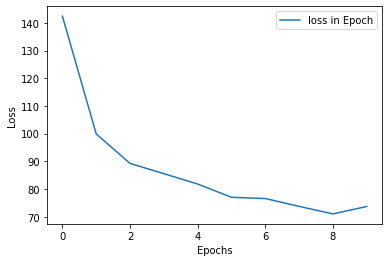

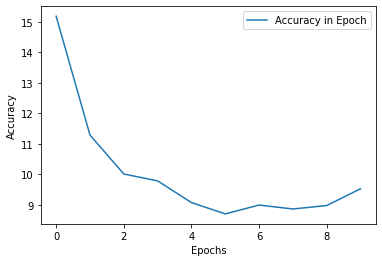

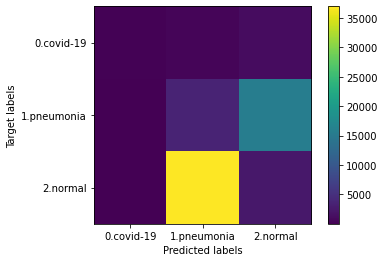

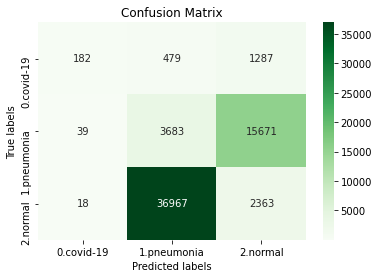

In [0]:
print("Train Epochs : " ,epochs_array)
print("Train Loss : ", loss_per_epoch)
print("Train Accuracy : ", acc_per_epoch)
plt.plot(epochs_array, loss_per_epoch, label = "loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, acc_per_epoch, label = "Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Train Set Confusion Matrix")
print(train_confusion_Matrix_vgg)
plt.imshow(train_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(train_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

Validation Epochs :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Validation loss :  [956.2640643119812, 1147.8862743377686, 1199.047555923462, 1309.2267208099365, 1312.9136095046997, 1293.4295454025269, 1277.814212322235, 1402.1160688400269, 1412.2672801017761, 1379.3045558929443]
Validation Accuracy :  [81.52866242038218, 83.43949044585987, 84.71337579617835, 86.78343949044586, 87.42038216560509, 87.10191082802548, 85.828025477707, 88.37579617834395, 88.85350318471338, 88.37579617834395]
Validation Set Confusion Matrix
[[  29   96  146]
 [   0 3742  223]
 [   1  321 1645]]


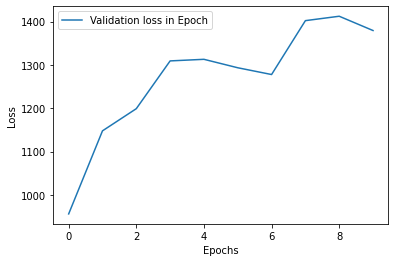

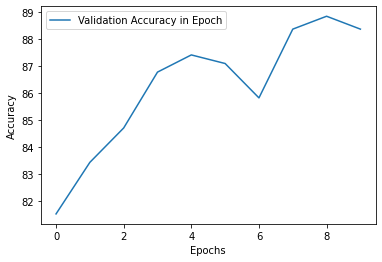

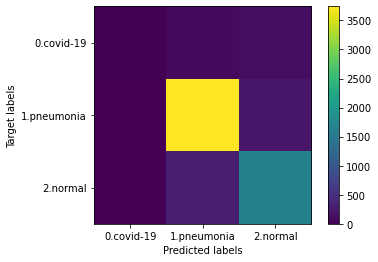

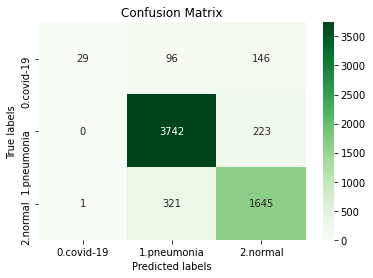

In [0]:
print("Validation Epochs : ", epochs_array)
print("Validation loss : ", val_loss_per_epoch)
print("Validation Accuracy : ", val_acc_per_epoch)
plt.plot(epochs_array, val_loss_per_epoch, label = "Validation loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, val_acc_per_epoch, label = "Validation Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Validation Set Confusion Matrix")
print(val_confusion_Matrix_vgg)
plt.imshow(val_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(val_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [0]:
#============================================== With Focal Loss ===========================

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
print('Output Layer of RESNET18 : ', resnet18.fc.out_features)

Output Layer of RESNET18 :  1000


In [0]:
num_features = resnet18.fc.in_features
resnet18.fc = None

In [0]:
resnet18.fc = nn.Sequential(
            nn.Linear(num_features, (22*10+100)), #(no of inputs, no of outputs)
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear((22*10+100), len(class_names))
        )

In [0]:
Epochs = 10

# alpha = 0.28
# gamma = 2.1
# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

# BCE = torch.nn.functional.binary_cross_entropy_with_logits(y_pred , t , reduction='none')
# pt = torch.exp(-BCE)
# fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

alpha = 0.28
gamma = 2.1

train_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
epochs_array = []
acc_per_epoch = []
loss_per_epoch = []
correct_train = 0
total_train = 0

val_confusion_Matrix_vgg = np.zeros((3,3), dtype=int)
val_epochs_array = []
val_acc_per_epoch = []
val_loss_per_epoch = []
correct_val = 0
total_val = 0

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total_train = 0
      correct_train = 0
      running_loss = 0

      val_running_loss = 0.0
      total_val = 0
      correct_val = 0
      val_running_loss = 0

      pbar = tqdm(enumerate(trainloader), position=0, leave=True)
      for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            one_hot_labels.append([0, 0, 1])
        one_hot_labels = torch.Tensor(list(one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        outputs = outputs.float()

        BCE = torch.nn.functional.binary_cross_entropy_with_logits(outputs.cuda() , one_hot_labels.cuda() , reduction='none')
        pt = torch.exp(-BCE)
        loss = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))

        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        total_train += labels.size(0)

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_train += 1
            train_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            train_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            train_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_train += 1
            train_confusion_Matrix_vgg[2][2] += 1

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        

        #====================================================== Validation =====================================================


      pbar2 = tqdm(enumerate(validationloader), position=0, leave=True)
      for i, data in pbar2:
        # get the inputs
        inputs, labels = data
        inputs, labels, criterion = inputs.to(device), labels.to(device), criterion.to(device)

        val_one_hot_labels = []
        for i in range(len(labels)):
          if(labels[i] == 0):
            val_one_hot_labels.append([1, 1, 0])
          elif(labels[i] == 1):
            val_one_hot_labels.append([0, 1, 0])
          elif(labels[i] == 2):
            val_one_hot_labels.append([0, 0, 1])
        val_one_hot_labels = torch.Tensor(list(val_one_hot_labels))

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        outputs = outputs.float()
 
        loss = criterion(outputs.cuda(), val_one_hot_labels.cuda())  #----> compute loss

        # outputs = resnet18(images)
        m = nn.Sigmoid()
        outputs = m(outputs)
        for i in range(outputs.shape[0]):
          for j in range(outputs.shape[1]):
            if (outputs[i][j] > 0.5):
              outputs[i][j] = 1
            elif (outputs[i][j] < 0.5):
              outputs[i][j] = 0

        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()
        for m in range(len(labels)):  
          total_val += 1
          if(labels[m] == 0 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[0][0] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[0][1] += 1
          elif(labels[m] == 0 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[0][2] += 1

          elif(labels[m] == 1 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][0] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            correct_val += 1
            val_confusion_Matrix_vgg[1][1] += 1
          elif(labels[m] == 1 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[1][2] += 1

          elif(labels[m] == 2 and outputs[m][0] == 1 and outputs[m][1] == 1 and outputs[m][2] == 0):
            val_confusion_Matrix_vgg[2][0] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 0 and outputs[m][2] == 1):
            val_confusion_Matrix_vgg[2][1] += 1
          elif(labels[m] == 2 and outputs[m][0] == 0 and outputs[m][1] == 1 and outputs[m][2] == 0):
            correct_val += 1
            val_confusion_Matrix_vgg[2][2] += 1

          val_running_loss += loss.item()
      #========================================================================================================================
        
      epochs_array.append(epoch)
      acc_per_epoch.append(100 * (correct_train / total_train))
      loss_per_epoch.append(running_loss)

      val_acc_per_epoch.append(100 * (correct_val / total_val))
      val_loss_per_epoch.append(val_running_loss)

torch.save(resnet18.state_dict(), "/content/drive/My Drive/Colab Notebooks/Deep Learning/SOBAN_BSCS16022_05_part2/resnet18_ft_with_FLoss.pth")

print('Finished Training')

cuda:0


Train Epoch: 0 [56/6200 (2%)]	Loss: 0.023337: : 388it [02:00,  3.22it/s]
40it [00:12,  3.28it/s]
Train Epoch: 1 [56/6200 (2%)]	Loss: 0.013743: : 388it [02:01,  3.20it/s]
40it [00:11,  3.34it/s]
Train Epoch: 2 [56/6200 (2%)]	Loss: 0.023896: : 388it [02:00,  3.23it/s]
40it [00:11,  3.34it/s]
Train Epoch: 3 [56/6200 (2%)]	Loss: 0.017223: : 388it [01:59,  3.25it/s]
40it [00:12,  3.33it/s]
Train Epoch: 4 [56/6200 (2%)]	Loss: 0.015835: : 388it [02:01,  3.20it/s]
40it [00:12,  3.33it/s]
Train Epoch: 5 [56/6200 (2%)]	Loss: 0.021893: : 388it [02:00,  3.23it/s]
40it [00:12,  3.29it/s]
Train Epoch: 6 [56/6200 (2%)]	Loss: 0.010838: : 388it [02:00,  3.21it/s]
40it [00:12,  3.31it/s]
Train Epoch: 7 [56/6200 (2%)]	Loss: 0.017567: : 388it [02:02,  3.17it/s]
40it [00:12,  3.14it/s]
Train Epoch: 8 [56/6200 (2%)]	Loss: 0.043163: : 388it [02:04,  3.11it/s]
40it [00:12,  3.15it/s]
Train Epoch: 9 [56/6200 (2%)]	Loss: 0.010675: : 388it [02:02,  3.18it/s]
40it [00:12,  3.28it/s]


Finished Training


In [0]:
print("Train Epochs : " ,epochs_array)
print("Train Loss : ", loss_per_epoch)
print("Train Accuracy : ", acc_per_epoch)
plt.plot(epochs_array, loss_per_epoch, label = "loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, acc_per_epoch, label = "Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Train Set Confusion Matrix")
print(train_confusion_Matrix_vgg)
plt.imshow(train_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(train_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [0]:
print("Validation Epochs : ", epochs_array)
print("Validation loss : ", val_loss_per_epoch)
print("Validation Accuracy : ", val_acc_per_epoch)
plt.plot(epochs_array, val_loss_per_epoch, label = "Validation loss in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.figure()
plt.plot(epochs_array, val_acc_per_epoch, label = "Validation Accuracy in Epoch")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
plt.figure()


import seaborn as sns
print("Validation Set Confusion Matrix")
print(val_confusion_Matrix_vgg)
plt.imshow(val_confusion_Matrix_vgg, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('Target labels')
plt.xlabel('Predicted labels')


plt.pause(0.01)
plt.figure()
ax= plt.subplot()
sns.heatmap(val_confusion_Matrix_vgg, annot=True, ax = ax  ,cmap='Greens' ,fmt='g');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [0]:
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data)

# dataiter = iter(testloader)

# print(testloader.dataset)
# images, labels = dataiter.next()
# show_databatch(images, labels)

In [21]:
import csv
count = 0

with open(os.path.join(data_dir, "BSCS16022_results.csv"), 'w', newline='') as f:
    writer = csv.writer(f)
    for p, data in tqdm(enumerate(testloader), position=0, leave=True):
          # get the inputs
          Image, Label = data
          Image, Label = Image.to(device), Label.to(device)

          zutput = vgg16(Image)             #----> forward pass
          
          #print(testloader.dataset.samples[i])

          m = nn.Sigmoid()
          zutput = m(zutput)
          #print(zutput)
          for i in range(zutput.shape[0]):
            for j in range(zutput.shape[1]):
              if (zutput[i][j] > 0.5):
                zutput[i][j] = 1
              elif (zutput[i][j] < 0.5):
                zutput[i][j] = 0

          zutput = zutput.cpu().data.numpy()
          print(zutput)
          writer.writerow(["{}.png".format(p), zutput[0][0], zutput[0][1], zutput[0][2]])

8it [00:00, 36.48it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


14it [00:00, 26.84it/s]

[[1. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


22it [00:00, 30.95it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


30it [00:00, 33.10it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


38it [00:01, 34.61it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


46it [00:01, 35.01it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


54it [00:01, 35.27it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


62it [00:01, 36.16it/s]

[[1. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


70it [00:02, 35.48it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


78it [00:02, 35.47it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


86it [00:02, 34.82it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


94it [00:02, 35.99it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


98it [00:02, 35.85it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


106it [00:03, 28.43it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


114it [00:03, 31.35it/s]

[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


122it [00:03, 33.56it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


130it [00:03, 34.45it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 1. 0.]]
[[0. 1. 0.]]


138it [00:04, 34.31it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


142it [00:04, 33.71it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[1. 1. 0.]]


152it [00:04, 36.22it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


160it [00:04, 35.15it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


168it [00:04, 35.65it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


176it [00:05, 35.62it/s]

[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


184it [00:05, 35.41it/s]

[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


192it [00:05, 35.78it/s]

[[0. 0. 1.]]
[[1. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


200it [00:05, 35.81it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


208it [00:06, 32.61it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


216it [00:06, 33.85it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 0.]]


224it [00:06, 34.26it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


232it [00:06, 35.14it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


240it [00:07, 36.01it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 1. 0.]]


248it [00:07, 35.73it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


256it [00:07, 36.11it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[1. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


264it [00:07, 35.88it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


272it [00:07, 35.86it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


280it [00:08, 35.14it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


288it [00:08, 34.75it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


296it [00:08, 34.29it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


304it [00:08, 35.07it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


312it [00:09, 35.69it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


320it [00:09, 35.86it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


328it [00:09, 25.42it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


336it [00:09, 29.92it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


344it [00:10, 32.20it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


352it [00:10, 32.27it/s]

[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


361it [00:10, 34.33it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


369it [00:10, 34.96it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


378it [00:11, 36.39it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


386it [00:11, 36.12it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


394it [00:11, 35.77it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


402it [00:11, 35.53it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


406it [00:11, 34.70it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


414it [00:12, 35.42it/s]

[[0. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


422it [00:12, 36.35it/s]

[[1. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


430it [00:12, 35.37it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


438it [00:12, 33.28it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


446it [00:13, 34.75it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


454it [00:13, 34.97it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


462it [00:13, 35.95it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


470it [00:13, 34.98it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


474it [00:13, 30.02it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[1. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


482it [00:14, 30.83it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 0.]]
[[0. 1. 0.]]


490it [00:14, 28.51it/s]

[[1. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


498it [00:14, 31.32it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


506it [00:14, 33.04it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


514it [00:15, 34.29it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


522it [00:15, 35.27it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


526it [00:15, 34.94it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


534it [00:15, 34.90it/s]

[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]


543it [00:15, 36.51it/s]

[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


551it [00:16, 36.71it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[1. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


559it [00:16, 35.76it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


567it [00:16, 36.32it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 1.]]
[[0. 0. 1.]]
[[1. 1. 0.]]


575it [00:16, 35.90it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


583it [00:17, 35.94it/s]

[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


591it [00:17, 35.80it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


599it [00:17, 35.57it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


603it [00:17, 35.37it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


611it [00:17, 35.05it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]


619it [00:18, 35.43it/s]

[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[1. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


629it [00:18, 34.18it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
